In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import torch, torchvision

import data
import model

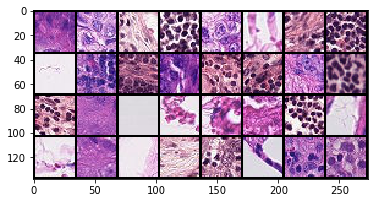

In [2]:
def softmax(x):
    return np.exp(x[:, 1]) / np.sum(np.exp(x), axis=1)

def evaluation(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

def imshow(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

def run_model(model, testloader):
    predictions = []
    result_labels = []
    for images, labels in tqdm(testloader):
        outputs = model(images)
        predictions += list(softmax(outputs.data.numpy()))
        result_labels += list(labels)
    predictions = np.array(predictions)
    return predictions, result_labels

def validate(model):
    result = defaultdict(int)
    for images, labels in tqdm(data.valid_loader):
        outputs = model(images)
        predictions = (outputs[:, 0] < outputs[:, 1]).data.numpy()
        labels = labels.data.numpy().astype(bool)
        result['tp'] += np.sum(labels & predictions)
        result['fp'] += np.sum(np.logical_not(labels) & predictions)
        result['tn'] += np.sum(np.logical_not(labels) & np.logical_not(predictions))
        result['fn'] += np.sum(labels & np.logical_not(predictions))
    return result

def accuracy(results):
    return (results['tp'] + results['tn']) / (results['tp'] + results['fp'] + results['tn'] +results['fn'] )

images, labels = iter(data.valid_loader).next()
imshow(torchvision.utils.make_grid(images))

In [6]:
#standard = model.StandardModel(load_weights=True)
standard_model = model.Standard(load_from='./model/standard.pth')

AttributeError: 'str' object has no attribute 'copy'

In [4]:
PATH = "./model/standard.pth"
model.standard.load_state_dict(torch.load(PATH))
results, outputs_model1 = validate(model.standard)
print(accuracy(results))
evaluation(model.standard, data.valid_loader)

AttributeError: module 'model.standard' has no attribute 'load_state_dict'

In [5]:
PATH = "./model/equivariant.pth"
model.equivariant.load_state_dict(torch.load(PATH))
results, outputs_model2  = validate(model.equivariant)
print(accuracy(results))
evaluation(model.equivariant, data.valid_loader)


0.79296875
Accuracy of the network on the 10000 test images: 79 %


In [70]:
labels, probs = run_model(model.standard, data.valid_loader)
labels.shape

torch.Size([32])

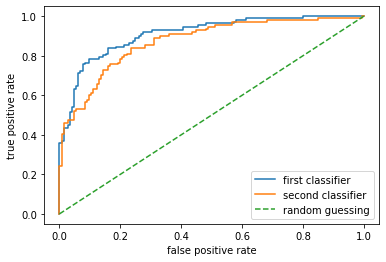

In [74]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc(probs, labels, title):
    fpr, tpr, _ = roc_curve(labels, probs)
    plt.plot(fpr, tpr, label=title)

    # sign test

plot_roc(*run_model(model.standard, data.valid_loader),'first classifier')
plot_roc(*run_model(model.equivariant, data.valid_loader), 'second classifier')
plt.plot([0, 1], label='random guessing', linestyle='dashed')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

In [7]:
# p-test